# Quality control

## Goal

Remove sequences and regions with low quality or potential adapter contamination from the raw sequence pool.

## Protocol

We use [Atropos](https://github.com/jdidion/atropos) ([Didion et al., 2017](https://peerj.com/articles/3720/)) for quality control.

The following command is adopted from Oecophylla, under [qc.rule](https://github.com/biocore/oecophylla/blob/7e2c8e030fb2e3943762156dd7d84fdf945dbc92/oecophylla/qc/qc.rule#L158).

```
atropos --threads {threads} {params.atropos} --report-file {log} --report-formats txt -o {temp_dir}/{f_fp} -p {temp_dir}/{r_fp} -pe1 {input.forward} -pe2 {input.reverse}
```

For parameters (`params.atropos`), we use the following:
```
-a GATCGGAAGAGCACACGTCTGAACTCCAGTCAC
-A GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT
-q 15 --minimum-length 100 --pair-filter any
```
Note: the two sequences are adapters to be removed (assuming the library prep kit is Illumina TruSeq or compatible models such as Kapa HyperPlus, which we use).


## Benchmark

The following benchmarks were obtained on 692 AGP shotgun samples, using 8 CPUs and 8 GB memory.

Basically, the run time is linear to the sample size, while memory consumption is linear and trivial.

For a typical dataset of 1 million sequences, this step will cost roughly 1 min 15 sec.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
%matplotlib inline

In [3]:
df = pd.read_table('support_files/benchmarks/atropos.tsv', index_col=0)
df.head()

,seqs,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load
sample,,,,,,,,,,
10317.000001062,981681,77.8203,0:01:17,2044.04,5353.94,893.25,1382.30,234.93,400.00,371.43
10317.000001079,1080144,80.1169,0:01:20,2103.91,5411.07,1097.82,1559.92,253.10,139.91,387.32
10317.000001086,302135,26.8115,0:00:26,921.31,4230.70,498.44,572.31,72.55,51.16,376.98
10317.000001089,746192,57.8219,0:00:57,1260.92,4570.15,1024.99,1102.19,175.45,144.57,498.26
10317.000001127,1028459,87.0529,0:01:27,2195.91,5504.84,1413.00,1460.25,242.76,207.27,595.14


In [4]:
df['mseqs'] = df['seqs'] / 1000000
df['mbram'] = df['max_rss'] / 1000

In [5]:
reg = linregress(df['mseqs'].values, df['s'].values)
reg

LinregressResult(slope=69.387990648100072, intercept=5.6821600677541539, rvalue=0.98989635320073421, pvalue=0.0, stderr=0.37144317405330479)

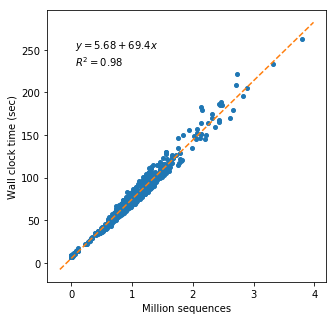

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
plt.plot(df['mseqs'], df['s'], 'o', markersize=4)
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.text(0.1, 0.8, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Million sequences')
plt.ylabel('Wall clock time (sec)');

In [7]:
reg = linregress(df['mseqs'].values, df['mbram'].values)
reg

LinregressResult(slope=2.1242883118433484, intercept=-0.030892124063678361, rvalue=0.9709008287509695, pvalue=0.0, stderr=0.019581897495066496)

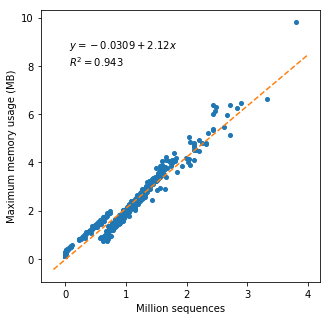

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
plt.plot(df['mseqs'], df['mbram'], 'o', markersize=4)
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.text(0.1, 0.8, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Million sequences')
plt.ylabel('Maximum memory usage (MB)');